### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import asdict
from typing import Dict, List, cast

import einops
import matplotlib.pyplot as plt
import torch

from einops import rearrange
from torch import Tensor
from torchvision.utils import make_grid

In [3]:
from flow_flowers.config import Config
from flow_flowers.data import DataTransform, FlowersDataset
from flow_flowers.model import AutoEncoder
from flow_flowers.utils import find_and_chdir

### Environment

In [4]:
torch.manual_seed(42)
find_and_chdir("config.yaml")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
config = Config.init("config.yaml")

### Perfom EDA on FlowersDataset

In [6]:
dataset = FlowersDataset(**asdict(config.data))

Dataset has 102 classes

In [7]:
dataset_labels = dataset.labels_
unique_labels = dataset_labels.unique()
print("Class count: ", unique_labels.nelement())

Class count:  102


Dataset has quite high class imbalance

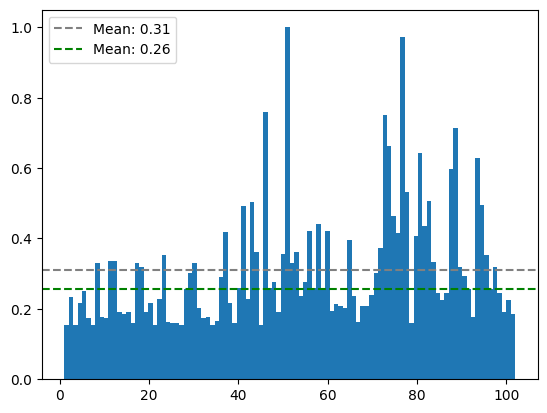

In [8]:
histogram = dataset_labels.float().histogram(bins=102)
norm_hist = histogram.hist / histogram.hist.max()

bin_edges = histogram.bin_edges
bin_width = bin_edges.diff()
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_mean = norm_hist.mean().item()
hist_median = norm_hist.median().item()

plt.bar(bin_centers, norm_hist, bin_width)
plt.axhline(norm_hist.mean().item(), linestyle="--", color="gray", label="Mean: {:.2}".format(hist_mean))
plt.axhline(norm_hist.median().item(), linestyle="--", color="green", label="Mean: {:.2}".format(hist_median))
plt.legend()

In [9]:
shapes = []
x_min: Dict = {"w_image": None, "h_image": None}
x_max: Dict = {"w_image": None, "h_image": None}

for x, y in (dataset[i] for i in range(len(dataset))):
    shapes.append(torch.tensor(x.size()))

    if x_min.get("w_image", None) is None:
        x_min["w_image"] = x
    if x_min.get("h_image", None) is None:
        x_min["h_image"] = x
    if x_max.get("w_image", None) is None:
        x_max["w_image"] = x
    if x_max.get("h_image", None) is None:
        x_max["h_image"] = x

    if x.size(1) < x_min["h_image"].size(1):
        x_min["h_image"] = x
    if x.size(2) < x_min["w_image"].size(2):
        x_min["w_image"] = x
    if x.size(1) > x_max["h_image"].size(1):
        x_max["h_image"] = x
    if x.size(2) > x_max["w_image"].size(2):
        x_max["w_image"] = x

x_outliers = [*x_min.values(), *x_max.values()]

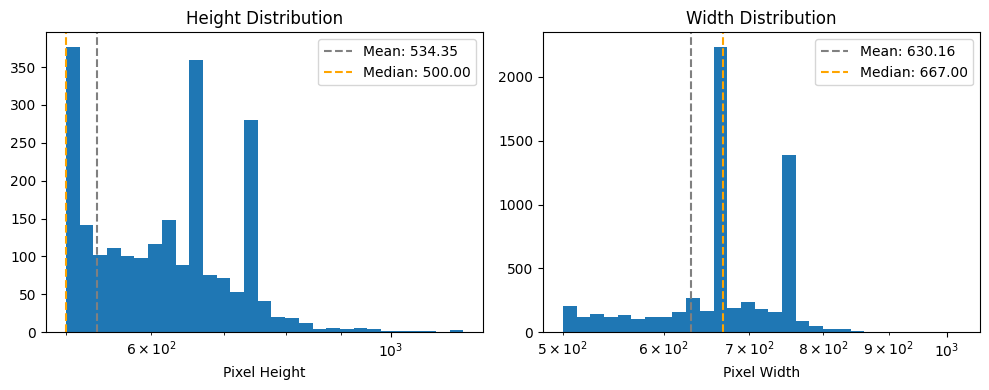

In [10]:
shapes: Tensor = einops.rearrange(shapes, "b s -> b s")

# Retrieve values
values_width = shapes[:, 2].float()
values_height = shapes[:, 1].float()
mean_width = values_width.mean().item()
mean_height = values_height.mean().item()
median_width = values_width.median().item()
median_height = values_height.median().item()

fig, (ax_h, ax_w) = plt.subplots(1, 2, figsize=(10, 4))

# Height histogram (same logic as width)
log_start_h = torch.log10(values_height.min()).item()
log_end_h = torch.log10(values_height.max()).item()
log_bins_h = torch.logspace(log_start_h, log_end_h, steps=30)
ax_h.hist(values_height, bins=log_bins_h)
ax_h.set_xscale("log")
ax_h.axvline(mean_height, color="gray", linestyle="--", label=f"Mean: {mean_height:.2f}")
ax_h.axvline(median_height, color="orange", linestyle="--", label=f"Median: {median_height:.2f}")
ax_h.set_title("Height Distribution")
ax_h.set_xlabel("Pixel Height")
ax_h.legend()

# Width histogram
log_start_w = torch.log10(values_width.min()).item()
log_end_w = torch.log10(values_width.max()).item()
log_bins_w = torch.logspace(log_start_w, log_end_w, steps=30)
ax_w.hist(values_width, bins=log_bins_w)
ax_w.set_xscale("log")
ax_w.axvline(mean_width, color="gray", linestyle="--", label=f"Mean: {mean_width:.2f}")
ax_w.axvline(median_width, color="orange", linestyle="--", label=f"Median: {median_width:.2f}")
ax_w.set_title("Width Distribution")
ax_w.set_xlabel("Pixel Width")
ax_w.legend()

plt.tight_layout()
plt.show()

In [11]:
def plot_image(ax, img):
    ax.imshow(img.permute((1, 2, 0)))
    h, w = img.shape[1], img.shape[2]
    ax.set_title(f"H: {h}, W: {w}")

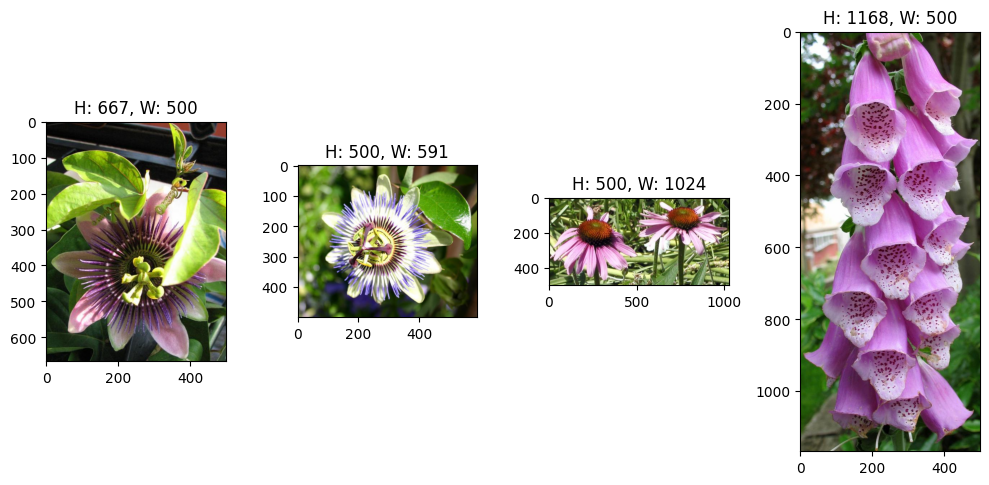

In [12]:
f, ax = plt.subplots(1, 4, figsize=(10, 5))

for axis, x in zip(ax, x_outliers):
    plot_image(axis, x)

f.tight_layout()

In [13]:
transform = DataTransform(**asdict(config.transform))


def transform_batch(x_batch: List[Tensor]) -> Tensor:
    x_output = [transform(x) for x in x_batch]
    x_output = rearrange(x_output, "b c h w -> b c h w")
    return x_output


def transform_grid(x_batch: List[Tensor]) -> Tensor:
    x_output = transform_batch(x_batch)
    x_output = make_grid(x_output, nrow=x_output.size(0))
    return x_output.permute((1, 2, 0))

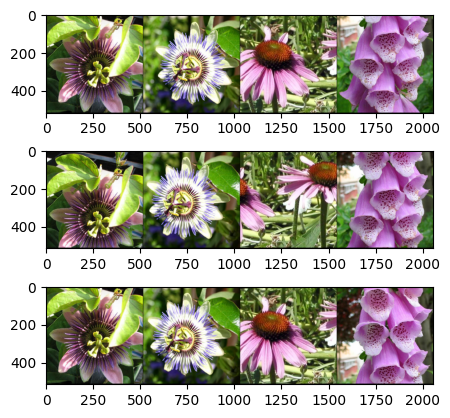

In [14]:
f, ax = plt.subplots(3, 1, figsize=(5, 5))

for axis in ax:
    axis.imshow(transform_grid(x_outliers))

plt.show()

### Assess DC-AE Reconstruction Quality

In [15]:
vae = AutoEncoder(**asdict(config.model.autoencoder)).to(device)

In [16]:
n_samples = 4
x_index = torch.randperm(len(dataset)).tolist()[:n_samples]
x_samples = [transform(dataset[i][0]) for i in x_index]
x_samples = einops.rearrange(x_samples, "b c h w -> b c h w")
x_samples = cast(Tensor, x_samples)
x_images = x_samples.to(device)

In [19]:
x_latent = vae.encode(x=x_images)

In [20]:
x_recon = vae.decode(x_latent)

In [25]:
x_recon.shape

torch.Size([4, 3, 512, 512])

In [28]:
x_images.aminmax()

torch.return_types.aminmax(
min=tensor(0., device='cuda:0'),
max=tensor(1., device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23767887..1.0815836].


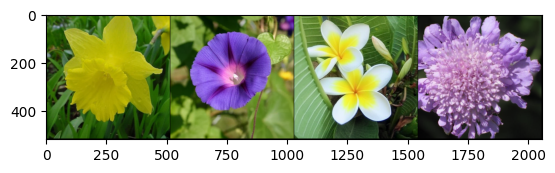

In [27]:
x_grid = make_grid(x_recon.cpu(), nrow=x_recon.size(0))
x_grid = rearrange(x_grid, "c h w -> h w c")
plt.imshow(x_grid)